In [1]:
from datetime import date, timedelta
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

months = ['Jan','Feb','Mar','Apr','Mai','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

# Define the date range to retrieve data for
start_date = str(date.today()-timedelta(days=5*365))
end_date = str(date.today())

# Dividend Settings
month_period = 6

def create_plot_tickers(tickers,syms):
    # Retrieve the stock data for each ticker and merge them into a single dataframe
    dfs = [ticker.history(start=start_date, end=end_date, interval='1mo') for ticker in tickers]

    all_total_return, all_dividends, all_stock_prices = [list(),list(),list()]
    for df in dfs:
        # fill NaN values with previous row values
        df['Close'] = df['Close'].fillna(method='ffill').fillna(0)
        df['Dividends'] = df['Dividends'].fillna(0)

        # train a linear regression model to predict changes in stock price
        # model at different pred depth
        timings = [36,24,12,6,3]
        model_zoo = list()
        for timing in timings:
            X = df['Close'].iloc[:-timing].to_numpy().reshape(-1, 1)  # use all but the last year as training data
            y = df['Close'].iloc[timing:].to_numpy()   # use all but the first year as target data
            model = LinearRegression()
            model.fit(X, y)
            model_zoo.append(model)

        # general model using all depths
        X = list()
        for it in range(max(timings),len(df['Close'])):
            X.append([model_zoo[num].predict(df['Close'].iloc[it-timings[num]].reshape(1, -1))[0] \
                      for num in range(len(model_zoo))])
        X = np.array(X)
        y = df['Close'].iloc[max(timings):].to_numpy()
        model = LinearRegression()
        model.fit(X, y)
    
        # stepwise yearly predictions with general model
        monthly_close = df
        for it in range(12//min(timings)):
            future_index = pd.date_range(date.today()+timedelta(days=it*31), periods=min(timings), freq='M')
            input_vec = [[model_zoo[num].predict(monthly_close['Close'].iloc[-timings[num]+offset].reshape(1, -1))[0] \
                          for num in range(len(model_zoo))] for offset in range(min(timings))]
            #for price_vec in input_vec: print(price_vec.shape)
            future_year_preds = pd.DataFrame({'Date': future_index, 'Close': model.predict(input_vec) }).set_index('Date')# \
                                                #for price_vec in input_vec]}).set_index('Date')
            monthly_close['Close'] = pd.concat([monthly_close['Close'], future_year_preds['Close']])
        monthly_close = monthly_close['Close']

        ## simple yearly
        #X = df['Close'].iloc[:-12].to_numpy().reshape(-1, 1)  # use all but the last year as training data
        #y = df['Close'].iloc[12:].to_numpy()   # use all but the first year as target data
        #year_model = LinearRegression()
        #year_model.fit(X, y)
        #future_index = pd.date_range(date.today(), periods=12, freq='M')
        #future_year_preds = pd.DataFrame({'Date': future_index, 'Close': [year_model.predict(price.reshape(1, -1))[0] \
        #                                    for price in df['Close'].iloc[-12:].to_numpy()]}).set_index('Date')
        #monthly_close = pd.concat([df['Close'], future_year_preds['Close']])

        # Grab the dividends for each ticker
        X = df['Dividends'].iloc[:-12].to_numpy().reshape(-1, 1)  # use all but the last year as training data
        y = df['Dividends'].iloc[12:].to_numpy()   # use all but the first year as target data
        year_model = LinearRegression()
        year_model.fit(X, y)
        future_index = pd.date_range(date.today(), periods=12, freq='M')
        future_year_preds = pd.DataFrame({'Date': future_index, 'Dividends': [year_model.predict(price.reshape(1, -1))[0] \
                                            for price in df['Dividends'].iloc[-12:].to_numpy()]}).set_index('Date')
        dividends = pd.concat([df['Dividends'], future_year_preds['Dividends']])

        # Calculate the monthly returns for each ticker
        monthly_returns = monthly_close.pct_change().replace(float('inf'), 0)

        # Calculate the cumulative growth for each ticker
        cumulative_growth = (1 + monthly_returns).cumprod()

        # Calculate the total return (growth + dividends) for each ticker
        total_return = cumulative_growth * (1 + dividends / monthly_close.shift(1).replace(0,1)).cumprod()

        all_dividends.append(dividends)
        all_total_return.append(total_return)
        all_stock_prices.append(monthly_close)


    # Plot cumulative growth and dividends
    ax1 = plt.figure(1,figsize=(10, 8)).gca()
    ax2 = plt.figure(2,figsize=(10, 8)).gca()
    ax3 = plt.figure(3,figsize=(10, 8)).gca()

    all_stock_prices = pd.concat(all_stock_prices, axis=1, keys=syms).fillna(method='ffill')
    all_dividends = pd.concat(all_dividends, axis=1, keys=syms).fillna(0)
    all_total_return = pd.concat(all_total_return, axis=1, keys=syms).fillna(method='ffill')*100

    all_stock_prices.plot.line(ax=ax1)
    all_dividends.plot.bar(ax=ax2,stacked=True)
    all_total_return.plot.line(ax=ax3)

    ax1.set_ylabel('Stock Price in $')
    ax2.set_ylabel('Dividends in $')
    ax3.set_ylabel('Total Return in %')

    ax2.set_xticks(ax2.get_xticks()[::month_period], labels=[months[it%12] \
                    for it in range(0,len(ax2.get_xticks()),month_period)])
    ax1.axvspan(ax1.get_xticks()[-2]+(ax1.get_xlim()[-1]-ax1.get_xticks()[-1]), \
                ax1.get_xlim()[-1], facecolor='green', alpha=0.2)
    ax2.axvspan(ax2.get_xticks()[-3]+(ax2.get_xlim()[-1]-ax2.get_xticks()[-1]), \
                ax2.get_xlim()[-1], facecolor='green', alpha=0.2)
    ax3.axvspan(ax3.get_xticks()[-2]+(ax3.get_xlim()[-1]-ax3.get_xticks()[-1]), \
                ax3.get_xlim()[-1], facecolor='green', alpha=0.2)
    plt.show()

# Dividend ETFs

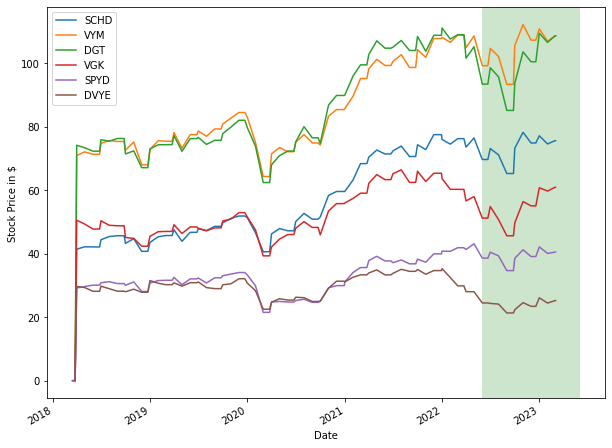

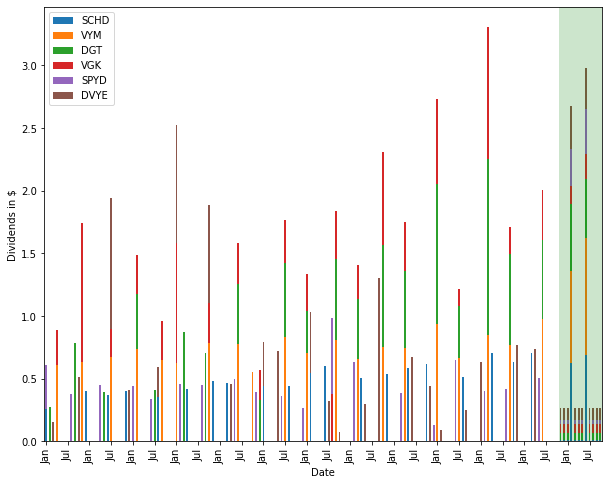

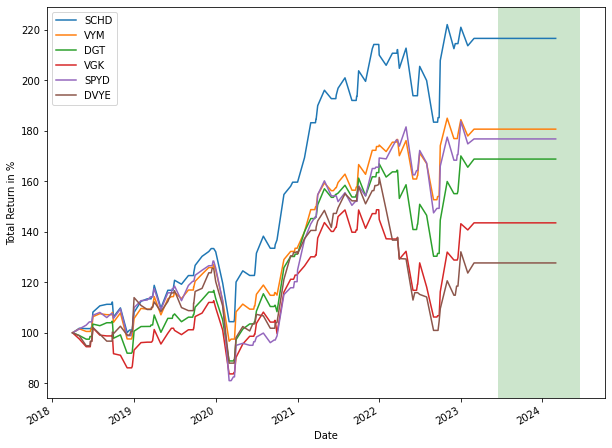

In [2]:
# Define the tickers to retrieve data for
syms = ['SCHD', 'VYM', 'DGT', 'VGK', 'SPYD', 'DVYE']
tickers = [yf.Ticker(sym) for sym in syms]

create_plot_tickers(tickers,syms)

# REITs

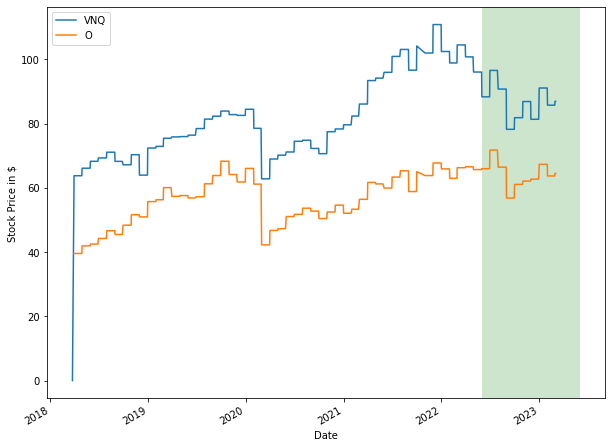

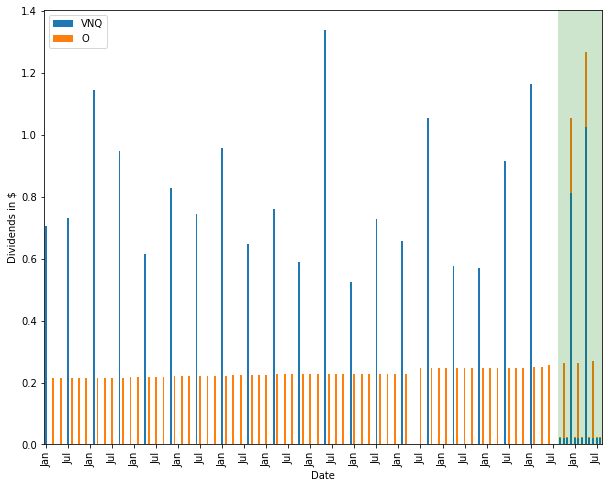

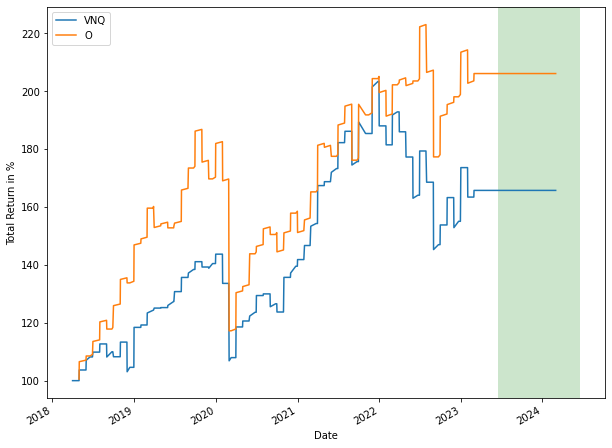

In [3]:
# Define the tickers to retrieve data for
syms = ['VNQ', 'O']
tickers = [yf.Ticker(sym) for sym in syms]

create_plot_tickers(tickers,syms)

# Stocks

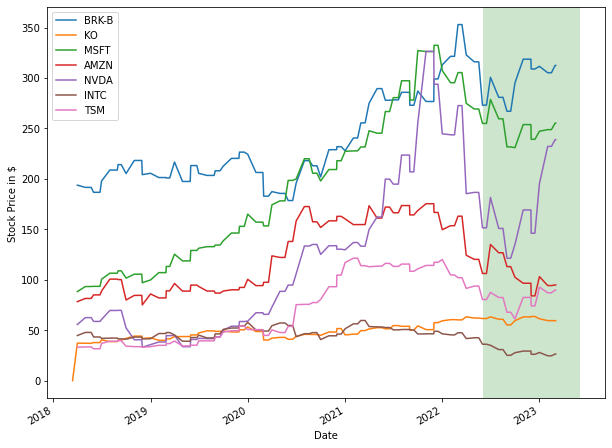

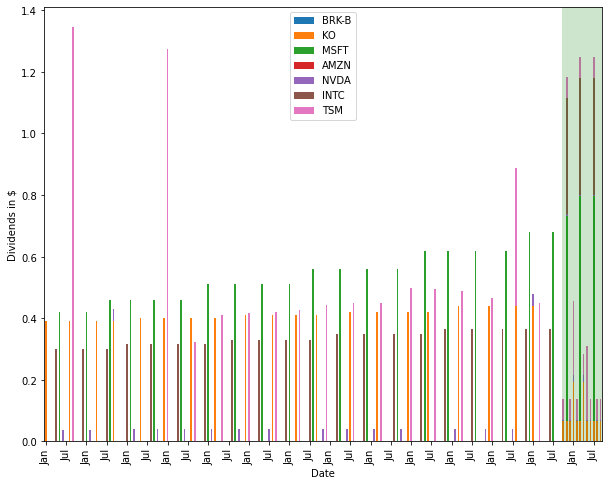

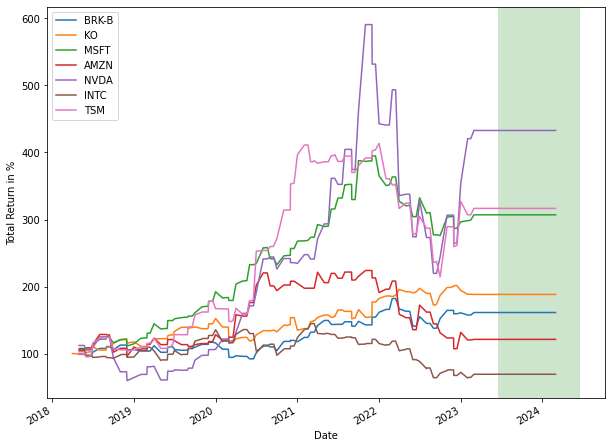

In [4]:
# Define the tickers to retrieve data for
syms = ['BRK-B', 'KO', 'MSFT', 'AMZN', 'NVDA', 'INTC', 'TSM']
tickers = [yf.Ticker(sym) for sym in syms]

create_plot_tickers(tickers,syms)